<a href="https://colab.research.google.com/github/Mayank-004/Google-Trend-Analysis/blob/main/KNN_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,accuracy_score
import seaborn as sns
import random
import time
random.seed(786)
from sklearn.metrics import mean_squared_error


In [23]:
dataset= pd.read_csv('multiTimeline.csv',error_bad_lines= False, sep=',')


In [24]:
dataset.drop(columns=['Time'], inplace= True)
dataset.rename(columns={"coffee: (United States)": "x_t0"},inplace=True)


dataset_new1= dataset.copy(deep=True)
dataset_new1.rename(columns={"x_t0": "x_t"},inplace=True)
dataset_new1.drop(dataset_new1.head(1).index, inplace= True)
dataset_new1=dataset_new1.reset_index()


dataset_new2= dataset.copy()
dataset_new2.rename(columns={"x_t0": "x_t+1"},inplace=True)
dataset_new2.drop(dataset_new2.head(2).index, inplace= True)
dataset_new2.reset_index(inplace=True)

In [25]:
#dataset.drop(dataset.tail.Index(2),inplace=True)
dataset.drop(dataset.tail(2).index,inplace=True) # drop last n rows
dataset_new1.drop(dataset_new1.tail(1).index,inplace=True) # drop last n rows


In [26]:
dataset_new3=pd.DataFrame(columns=['x_t0','x_t','x_t2'])

dataset_new3['x_t0']=dataset['x_t0']
dataset_new3['x_t']= dataset_new1['x_t']
dataset_new3['x_t2']=dataset_new2['x_t+1']

In [27]:
dataset=dataset_new3

In [28]:
dataset

,x_t0,x_t,x_t2
0,38,36,29
1,36,29,30
2,29,30,29
3,30,29,34
4,29,34,52
...,...,...,...
161,52,48,48
162,48,48,45
163,48,45,44
164,45,44,42


In [29]:
type(dataset)

pandas.core.frame.DataFrame

### Data Visualization

In [30]:
dataset.dtypes

x_t0    int64
x_t     int64
x_t2    int64
dtype: object

In [31]:
#Count Missing Data
missing = dataset.isna().sum().sort_values(ascending = False)
percent_missing = ((missing / dataset.isnull().count()) * 100).sort_values(ascending = False)
missing_df = pd.concat([missing,percent_missing], axis = 1, keys = ['Total', 'Percent'],sort = False)
missing_df[missing_df['Total'] >= 1]

,Total,Percent


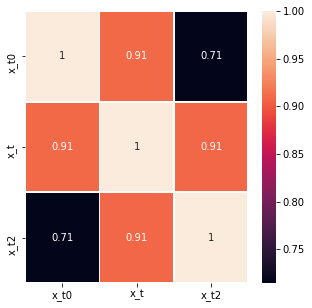

In [32]:
df1=dataset.copy(deep=True)

# Filtering all Categorical variables
vars_categorical = list(df1.select_dtypes(['object']).columns)

for x in vars_categorical:
    df1.loc[:,x] = df1.loc[:,x].astype(float)


corrMatrix= df1.corr()

fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches

sns.heatmap(corrMatrix, annot=True,linewidth=0.8)
plt.show()

In [33]:
X = dataset.iloc[:,0:-1]
y = dataset.iloc[:,-1]

In [34]:
X

,x_t0,x_t
0,38,36
1,36,29
2,29,30
3,30,29
4,29,34
...,...,...
161,52,48
162,48,48
163,48,45
164,45,44


In [35]:
X_train = X.head(X.shape[0] -1)
y_train=y.head(y.shape[0]-1)
X_test= X.tail(1)
y_test=y.tail(1)

In [36]:
y_train=y_train.to_numpy()

y_test=y_test.to_numpy()

In [37]:
X_train

,x_t0,x_t
0,38,36
1,36,29
2,29,30
3,30,29
4,29,34
...,...,...
160,58,52
161,52,48
162,48,48
163,48,45


In [38]:
y_train

array([ 29,  30,  29,  34,  52,  61,  59,  57,  54,  52,  50,  47,  45,
        43,  41,  42,  41,  42,  42,  43,  42,  41,  39,  34,  31,  29,
        28,  32,  52,  63,  63,  61,  55,  53,  48,  46,  45,  44,  41,
        42,  40,  40,  40,  40,  39,  39,  37,  33,  28,  26,  29,  32,
        49,  61,  64,  59,  59,  54,  49,  48,  44,  41,  40,  39,  40,
        39,  38,  39,  41,  39,  39,  36,  28,  32,  30,  34,  50,  64,
        62,  60,  57,  53,  49,  45,  44,  42,  41,  40,  39,  39,  39,
        40,  38,  38,  34,  32,  27,  28,  29,  32,  50,  67,  68,  66,
        62,  58,  53,  49,  48,  44,  45,  43,  41,  42,  41,  42,  41,
        40,  37,  35,  28,  30,  31,  36,  63,  82,  96,  98,  91,  84,
        81,  67,  61,  58,  53,  52,  49,  47,  45,  45,  43,  39,  37,
        32,  26,  24,  27,  29,  44,  84,  95, 100,  97,  90,  78,  69,
        70,  59,  58,  52,  48,  48,  45,  44,  42])

In [39]:
type(y_test)

numpy.ndarray

In [40]:
type(X_test)

pandas.core.frame.DataFrame

In [41]:

## defining a reusable function to evaluate model performance

def eval_result(model_name,y_train,y_predtrain,y_test,y_predtest,n_neighbors):

    rmse_train = mean_squared_error(y_train, y_predtrain, squared=False)
    print( f"RMSE Train error for k= {n_neighbors} is {rmse_train}")
    rmse_test = mean_squared_error(y_test, y_predtest, squared=False)
    print( f"RMSE Test error for k= {n_neighbors} is {rmse_test}")

  

In [42]:
# reusable function to calculate run time for model training

def run_model(model):
    t0=time.time()
    model.fit(X_train,y_train)
    time_taken= time.time()- t0
    print(f'Time taken: {time_taken}')

# kNN Model

In [43]:
# p = 2 is equivalent to using the euclidean distance
# weights = 'distance' means closer points are weighted more heavily than further away points
# weights = 'Uniform' means every point is given equal weight.
n_neighbors = 3
model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance',algorithm='auto',p=2)
#run_model(model1)
model1.fit(X_train,y_train)

y_hat_train = model1.predict(X_train)
y_hat_test = model1.predict(X_test)
#y_hat_test=pd.DataFrame(y_hat_test)
eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)


RMSE Train error for k= 3 is 1.3684762594679065
RMSE Test error for k= 3 is 9.0


In [44]:
mean_squared_error(y_test, y_hat_test, squared=False)

9.0

In [45]:
type(y_hat_test)

numpy.ndarray

In [47]:
# p = 2 is equivalent to using the euclidean distance

for n_neighbors in range(1,10):
  model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance',algorithm='auto',p=2)
  #run_model(model1)
  model1.fit(X_train,y_train)

  y_hat_train = model1.predict(X_train)
  y_hat_test = model1.predict(X_test)
  print(f'Prediction for K= {n_neighbors} is {y_hat_test}')
  print(f'Actual for K= {n_neighbors} is {y_test}')
  y_hat_test=pd.DataFrame(y_hat_test)

  eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)

Prediction for K= 1 is [41.]
Actual for K= 1 is [32]
RMSE Train error for k= 1 is 1.9053354114966294
RMSE Test error for k= 1 is 9.0
Prediction for K= 2 is [41.]
Actual for K= 2 is [32]
RMSE Train error for k= 2 is 1.387716677048156
RMSE Test error for k= 2 is 9.0
Prediction for K= 3 is [41.]
Actual for K= 3 is [32]
RMSE Train error for k= 3 is 1.3684762594679065
RMSE Test error for k= 3 is 9.0
Prediction for K= 4 is [41.]
Actual for K= 4 is [32]
RMSE Train error for k= 4 is 1.3617706091406114
RMSE Test error for k= 4 is 9.0
Prediction for K= 5 is [41.]
Actual for K= 5 is [32]
RMSE Train error for k= 5 is 1.3592927453925323
RMSE Test error for k= 5 is 9.0
Prediction for K= 6 is [41.]
Actual for K= 6 is [32]
RMSE Train error for k= 6 is 1.3592927453925323
RMSE Test error for k= 6 is 9.0
Prediction for K= 7 is [41.]
Actual for K= 7 is [32]
RMSE Train error for k= 7 is 1.3592927453925323
RMSE Test error for k= 7 is 9.0
Prediction for K= 8 is [41.]
Actual for K= 8 is [32]
RMSE Train error 

In [51]:
# p = 2 is equivalent to using the euclidean distance

for n_neighbors in range(1,10):
  model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='uniform',algorithm='auto',p=2)
  #run_model(model1)
  model1.fit(X_train,y_train)

  y_hat_train = model1.predict(X_train)
  y_hat_test = model1.predict(X_test)
  print(f'Prediction for K= {n_neighbors} is {y_hat_test}')
  print(f'Actual for K= {n_neighbors} is {y_test}')
  y_hat_test=pd.DataFrame(y_hat_test)

  eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)

Prediction for K= 1 is [41.]
Actual for K= 1 is [32]
RMSE Train error for k= 1 is 1.9053354114966294
RMSE Test error for k= 1 is 9.0
Prediction for K= 2 is [41.]
Actual for K= 2 is [32]
RMSE Train error for k= 2 is 3.141125063837266
RMSE Test error for k= 2 is 9.0
Prediction for K= 3 is [40.66666667]
Actual for K= 3 is [32]
RMSE Train error for k= 3 is 3.4685697961806143
RMSE Test error for k= 3 is 8.666666666666664
Prediction for K= 4 is [41.]
Actual for K= 4 is [32]
RMSE Train error for k= 4 is 3.8985719996382824
RMSE Test error for k= 4 is 9.0
Prediction for K= 5 is [41.2]
Actual for K= 5 is [32]
RMSE Train error for k= 5 is 4.299147202256125
RMSE Test error for k= 5 is 9.200000000000003
Prediction for K= 6 is [41.33333333]
Actual for K= 6 is [32]
RMSE Train error for k= 6 is 4.442467994878736
RMSE Test error for k= 6 is 9.333333333333336
Prediction for K= 7 is [41.28571429]
Actual for K= 7 is [32]
RMSE Train error for k= 7 is 4.575174331191282
RMSE Test error for k= 7 is 9.28571428

In [52]:
# p = 1 is equivalent to using the manhattan distance

for n_neighbors in range(1,10):
  model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance',algorithm='auto',p=1)
  run_model(model1)
  y_hat_train = model1.predict(X_train)
  y_hat_test = model1.predict(X_test)
  print(f'Prediction for K= {n_neighbors} is {y_hat_test}')
  print(f'Actual for K= {n_neighbors} is {y_test}')
  y_hat_test=pd.DataFrame(y_hat_test)

  eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)

Time taken: 0.0031130313873291016
Prediction for K= 1 is [41.]
Actual for K= 1 is [32]
RMSE Train error for k= 1 is 1.9053354114966294
RMSE Test error for k= 1 is 9.0
Time taken: 0.0007624626159667969
Prediction for K= 2 is [41.]
Actual for K= 2 is [32]
RMSE Train error for k= 2 is 1.387716677048156
RMSE Test error for k= 2 is 9.0
Time taken: 0.0007174015045166016
Prediction for K= 3 is [41.]
Actual for K= 3 is [32]
RMSE Train error for k= 3 is 1.3684762594679065
RMSE Test error for k= 3 is 9.0
Time taken: 0.0007224082946777344
Prediction for K= 4 is [41.]
Actual for K= 4 is [32]
RMSE Train error for k= 4 is 1.3617706091406114
RMSE Test error for k= 4 is 9.0
Time taken: 0.0007581710815429688
Prediction for K= 5 is [41.]
Actual for K= 5 is [32]
RMSE Train error for k= 5 is 1.3592927453925323
RMSE Test error for k= 5 is 9.0
Time taken: 0.0007288455963134766
Prediction for K= 6 is [41.]
Actual for K= 6 is [32]
RMSE Train error for k= 6 is 1.3592927453925323
RMSE Test error for k= 6 is 9.0

In [48]:
# p = 1 is equivalent to using the manhattan distance

for n_neighbors in range(1,10):
  model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='uniform',algorithm='auto',p=1)
  run_model(model1)
  y_hat_train = model1.predict(X_train)
  y_hat_test = model1.predict(X_test)
  print(f'Prediction for K= {n_neighbors} is {y_hat_test}')
  print(f'Actual for K= {n_neighbors} is {y_test}')
  y_hat_test=pd.DataFrame(y_hat_test)

  eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)

Time taken: 0.0011925697326660156
Prediction for K= 1 is [41.]
Actual for K= 1 is [32]
RMSE Train error for k= 1 is 1.9053354114966294
RMSE Test error for k= 1 is 9.0
Time taken: 0.006585597991943359
Prediction for K= 2 is [41.]
Actual for K= 2 is [32]
RMSE Train error for k= 2 is 2.8643577734887544
RMSE Test error for k= 2 is 9.0
Time taken: 0.0008065700531005859
Prediction for K= 3 is [40.66666667]
Actual for K= 3 is [32]
RMSE Train error for k= 3 is 3.5993826631181562
RMSE Test error for k= 3 is 8.666666666666664
Time taken: 0.0007674694061279297
Prediction for K= 4 is [41.]
Actual for K= 4 is [32]
RMSE Train error for k= 4 is 4.238442395431834
RMSE Test error for k= 4 is 9.0
Time taken: 0.0007805824279785156
Prediction for K= 5 is [41.2]
Actual for K= 5 is [32]
RMSE Train error for k= 5 is 4.580565004186247
RMSE Test error for k= 5 is 9.200000000000003
Time taken: 0.0016727447509765625
Prediction for K= 6 is [41.33333333]
Actual for K= 6 is [32]
RMSE Train error for k= 6 is 4.73339

In [53]:
# p = 3 is equivalent to using the minkowski distance

for n_neighbors in range(1,10):
  model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance',algorithm='auto',p=3)
  run_model(model1)
  y_hat_train = model1.predict(X_train)
  y_hat_test = model1.predict(X_test)
  print(f'Prediction for K= {n_neighbors} is {y_hat_test}')
  print(f'Actual for K= {n_neighbors} is {y_test}')

  eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)

Time taken: 0.004352569580078125
Prediction for K= 1 is [41.]
Actual for K= 1 is [32]
RMSE Train error for k= 1 is 1.9053354114966294
RMSE Test error for k= 1 is 9.0
Time taken: 0.0022161006927490234
Prediction for K= 2 is [41.]
Actual for K= 2 is [32]
RMSE Train error for k= 2 is 1.387716677048156
RMSE Test error for k= 2 is 9.0
Time taken: 0.0008840560913085938
Prediction for K= 3 is [41.]
Actual for K= 3 is [32]
RMSE Train error for k= 3 is 1.3684762594679065
RMSE Test error for k= 3 is 9.0
Time taken: 0.0008571147918701172
Prediction for K= 4 is [41.]
Actual for K= 4 is [32]
RMSE Train error for k= 4 is 1.3617706091406114
RMSE Test error for k= 4 is 9.0
Time taken: 0.0007977485656738281
Prediction for K= 5 is [41.]
Actual for K= 5 is [32]
RMSE Train error for k= 5 is 1.3592927453925323
RMSE Test error for k= 5 is 9.0
Time taken: 0.0008428096771240234
Prediction for K= 6 is [41.]
Actual for K= 6 is [32]
RMSE Train error for k= 6 is 1.3592927453925323
RMSE Test error for k= 6 is 9.0


In [49]:
# p = 3 is equivalent to using the minkowski distance

for n_neighbors in range(1,10):
  model1 = KNeighborsRegressor(n_neighbors=n_neighbors,weights='uniform',algorithm='auto',p=3)
  run_model(model1)
  y_hat_train = model1.predict(X_train)
  y_hat_test = model1.predict(X_test)
  print(f'Prediction for K= {n_neighbors} is {y_hat_test}')
  print(f'Actual for K= {n_neighbors} is {y_test}')

  eval_result(model1,y_train,y_hat_train,y_test,y_hat_test,n_neighbors)

Time taken: 0.001528024673461914
Prediction for K= 1 is [41.]
Actual for K= 1 is [32]
RMSE Train error for k= 1 is 1.9053354114966294
RMSE Test error for k= 1 is 9.0
Time taken: 0.0010914802551269531
Prediction for K= 2 is [41.]
Actual for K= 2 is [32]
RMSE Train error for k= 2 is 3.141125063837266
RMSE Test error for k= 2 is 9.0
Time taken: 0.002039670944213867
Prediction for K= 3 is [40.66666667]
Actual for K= 3 is [32]
RMSE Train error for k= 3 is 3.4685697961806143
RMSE Test error for k= 3 is 8.666666666666664
Time taken: 0.0008099079132080078
Prediction for K= 4 is [41.]
Actual for K= 4 is [32]
RMSE Train error for k= 4 is 3.869999216975882
RMSE Test error for k= 4 is 9.0
Time taken: 0.0012993812561035156
Prediction for K= 5 is [41.2]
Actual for K= 5 is [32]
RMSE Train error for k= 5 is 4.214549114961676
RMSE Test error for k= 5 is 9.200000000000003
Time taken: 0.0009510517120361328
Prediction for K= 6 is [41.33333333]
Actual for K= 6 is [32]
RMSE Train error for k= 6 is 4.3943260